# Visão Computacional - Predição de Glicemia
Aluno: Leandro Duque Mussio

# Pré-processamento

## Configuração do Ambiente

### Montagem do drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


### Instalação de dependências

In [ ]:
pip install wfdb plotly nbformat scipy neurokit2 PyWavelets catboost tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.1/693.1 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 81.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.3 MB/s eta 0:00:00


### Variáveis de Ambiente

In [ ]:
SEED = 42

## Extração dos dados

### Montagem do DataFrame

In [ ]:
import os
import re
import wfdb
import numpy as np
import pandas as pd
from tqdm import tqdm

# Base directory onde os registros estão
base_directory = "/content/drive/MyDrive/Colab Notebooks/Mestrado/Visao/wfdb_records/"

# Gerar os IDs dinamicamente a partir das pastas no diretório
record_ids = [d for d in os.listdir(base_directory) if os.path.isdir(os.path.join(base_directory, d))]

# Montar os caminhos completos para cada registro no formato esperado
ppg_records = [os.path.join(record_id, f"{record_id}_PPG") for record_id in record_ids]

# Variável para armazenar os dados processados
dataset = []

# Iterar sobre cada registro e processá-lo
print(f"Número total de registros: {len(ppg_records)}")
for record in tqdm(ppg_records, desc="Processando Registros"):
    # Extrair o ID do registro
    record_id = re.search(r'(\d+)', record).group(0)

    # Construir o caminho completo para o registro
    full_record_path = os.path.join(base_directory, record)

    # Carregar o sinal usando wfdb
    try:
        signals, fields = wfdb.rdsamp(full_record_path)

        # Calcular o tempo em segundos
        tempo_segundos = signals.shape[0] / fields['fs']
        t = np.linspace(0, tempo_segundos, signals.shape[0])

        # Adicionar os dados ao dataset
        dataset.append({
            'ppg_r': signals[:, 0],
            'ppg_g': signals[:, 1],
            'ppg_b': signals[:, 2],
            'time': t,
            'fs': fields['fs'],
            'sig_len': len(signals[:, 0]),
            'name': record_id
        })

    except Exception as e:
        print(f"Erro ao carregar o registro {record}: {e}")

# Criar um DataFrame com os dados processados
df = pd.DataFrame(dataset)

# Exibir as primeiras linhas do DataFrame
print(df.head())

Número total de registros: 21


Processando Registros: 100%|██████████| 21/21 [00:10<00:00,  2.08it/s]

                                               ppg_r  \
0  [-190.76369366075014, -190.72018291735262, -19...   
1  [-187.3844247589103, -187.39804160454065, -187...   
2  [-190.24881884489105, -189.7222588639106, -189...   
3  [-187.35160369467397, -187.3591275640044, -187...   
4  [-187.23699682450933, -186.99787120358874, -18...   

                                               ppg_g  \
0  [-55.76617716071521, -55.687988457100374, -55....   
1  [-53.415102683274476, -53.47135470643804, -53....   
2  [-54.98782175583263, -54.603306306198114, -54....   
3  [-53.9819054055425, -54.08115498239253, -54.15...   
4  [-53.62037382497674, -53.55031059819387, -53.5...   

                                               ppg_b  \
0  [-39.73144334663026, -39.68423086790767, -39.5...   
1  [-39.08127840074809, -39.1815379583108, -39.21...   
2  [-40.455202002548866, -40.18693863729607, -39....   
3  [-26.468694620732343, -26.557872706501872, -26...   
4  [-26.120047759913344, -26.248032390330117, 

### Visualização dos sinais carregados

In [ ]:
print(df.shape)
print(df.head())

(21, 7)
                                               ppg_r  \
0  [-190.76369366075014, -190.72018291735262, -19...   
1  [-187.3844247589103, -187.39804160454065, -187...   
2  [-190.24881884489105, -189.7222588639106, -189...   
3  [-187.35160369467397, -187.3591275640044, -187...   
4  [-187.23699682450933, -186.99787120358874, -18...   

                                               ppg_g  \
0  [-55.76617716071521, -55.687988457100374, -55....   
1  [-53.415102683274476, -53.47135470643804, -53....   
2  [-54.98782175583263, -54.603306306198114, -54....   
3  [-53.9819054055425, -54.08115498239253, -54.15...   
4  [-53.62037382497674, -53.55031059819387, -53.5...   

                                               ppg_b  \
0  [-39.73144334663026, -39.68423086790767, -39.5...   
1  [-39.08127840074809, -39.1815379583108, -39.21...   
2  [-40.455202002548866, -40.18693863729607, -39....   
3  [-26.468694620732343, -26.557872706501872, -26...   
4  [-26.120047759913344, -26.248032390

In [ ]:
import plotly.graph_objects as go

# Escolha de 3 sinais aleatórios com base na seed
np.random.seed(SEED)
indexes = np.random.choice(df.index, 3, replace=False)

fig = go.Figure()
for i, index in enumerate(indexes):
    fig.add_trace(go.Scatter(x=df['time'][i], y=df['ppg_g'][i], mode='lines', name=df['name'][i]))
fig.update_layout(title='PPG Signals')
fig.show()


### Carregamento de Anotações

In [ ]:
csv_path = "/content/drive/MyDrive/Colab Notebooks/Mestrado/Visao/subject-info.csv"


In [ ]:
import pandas as pd

df_final = df.copy()

# Carregar os CSVs
subject_info = pd.read_csv(csv_path)

# Remover possíveis espaços dos nomes das colunas
subject_info.columns = subject_info.columns.str.strip()

# Padronização dos tipos de coluna para correlacionamento
df_final['name'] = df_final['name'].astype(int)
# quality_hr_ann['ID'] = quality_hr_ann['ID'].astype(int)
subject_info['ID'] = subject_info['ID'].astype(int)
# subject_info = subject_info.rename(columns={"glicemia": "Glycaemia [mg/dL]"})

# Mesclar o DataFrame resultante com subject_info baseado na coluna 'name' e 'ID'
df_final = pd.merge(df_final, subject_info, left_on='name', right_on='ID', how='left')



In [ ]:
print(df_final.head())
print(df_final.shape)

                                               ppg_r  \
0  [-190.76369366075014, -190.72018291735262, -19...   
1  [-187.3844247589103, -187.39804160454065, -187...   
2  [-190.24881884489105, -189.7222588639106, -189...   
3  [-187.35160369467397, -187.3591275640044, -187...   
4  [-187.23699682450933, -186.99787120358874, -18...   

                                               ppg_g  \
0  [-55.76617716071521, -55.687988457100374, -55....   
1  [-53.415102683274476, -53.47135470643804, -53....   
2  [-54.98782175583263, -54.603306306198114, -54....   
3  [-53.9819054055425, -54.08115498239253, -54.15...   
4  [-53.62037382497674, -53.55031059819387, -53.5...   

                                               ppg_b  \
0  [-39.73144334663026, -39.68423086790767, -39.5...   
1  [-39.08127840074809, -39.1815379583108, -39.21...   
2  [-40.455202002548866, -40.18693863729607, -39....   
3  [-26.468694620732343, -26.557872706501872, -26...   
4  [-26.120047759913344, -26.248032390330117, 

In [ ]:
df_final_bkp = df_final.copy()

## Transformação dos dados

### Filtragem dos sinais

#### Visualização dos sinais brutos

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

np.random.seed(SEED)
indexes = [12,13,14]
fig = make_subplots(rows=3, cols=1, shared_xaxes=True)
for i, index in enumerate(indexes):
    fig.add_trace(go.Scatter(x=df_final['time'][index], y=df_final['ppg_r'][index], mode='lines', name="{0}".format(df_final['name'][index])), row=i+1, col=1)
    fig.update_yaxes(title_text="Amplitude", row=i+1, col=1)
    fig.update_xaxes(title_text="Time (s)", row=i+1, col=1, showticklabels=True)

fig.update_layout(height=3000, width=800, title_text="20 Random PPG Signals")
fig.show()

##### Espectro do sinal

In [ ]:
from scipy import signal
import numpy as np
import plotly.graph_objects as go

# "Sinais “periódicos” (energia infinita) – o resultado é influenciado pelo quantidade N de amostras
# consideradas, fator de escala, devido a simetria, é 2/N (para o espectro de 0 a Fs/2)" - Aula 5 - Slide 54
def fft(sinal, Fs, N, titulo='Espectro ECG', periodico=True):
    """
    Função para calcular a FFT de um sinal e apresentar o espectro.

    Parameters
    ----------
    sinal : DataFrame
        DataFrame contendo o sinal a ser analisado.
    Fs : int
        Frequência de amostragem do sinal.
    N : int
        Número de amostras do sinal.
    periodico : bool, optional
        Se o sinal é periódico ou não. O padrão é True.

    Returns
    -------
    None
    """

    freq = np.linspace(0, (N-1)*Fs/N, N)

    if periodico:
        fft_1=(2*np.abs(np.fft.fft(sinal))/N)
    else:
        fft_1=(np.abs(np.fft.fft(sinal))/Fs)

    fft_1 = fft_1[:N//2]
    f1, Pxx1 = signal.periodogram(sinal,fs=Fs,window='hann',nfft=N,scaling='spectrum')
    f11, Pxx11 = signal.periodogram(sinal,fs=Fs,window='hann',nfft=N,scaling='density')
    f2, Pxx2 = signal.welch(sinal, fs=Fs, window='hann', nfft=N, detrend='constant', scaling='spectrum', average='mean')
    f22, Pxx22 = signal.welch(sinal, fs=Fs, window='hann', nfft=N, detrend='constant', scaling='density', average='mean')

    fig = go.Figure()

    # Customize colors and labels for each DataFrame
    colors = ['red', 'green', 'blue', 'yellow', 'purple']
    labels = ['FFT', 'Periodograma - spectrum', 'Welch - spectrum', 'Periodograma - density', 'Welch - density']

    # Add traces for each DataFrame
    fig.add_trace(go.Scatter(x=freq, y=fft_1, mode='lines', name=labels[0], line=dict(color=colors[0]))) # (mV)
    fig.add_trace(go.Scatter(x=f1, y=np.sqrt(Pxx1), mode='lines', name=labels[1], line=dict(color=colors[1]))) # (mV RMS)
    fig.add_trace(go.Scatter(x=f2, y=np.sqrt(Pxx2), mode='lines', name=labels[2], line=dict(color=colors[2]))) # (mV RMS)
    fig.add_trace(go.Scatter(x=f11, y=Pxx11, mode='lines', name=labels[3], line=dict(color=colors[3]))) # (mV**2/Hz)
    fig.add_trace(go.Scatter(x=f22, y=Pxx22, mode='lines', name=labels[4], line=dict(color=colors[4]))) # (mV**2/Hz)
    fig.update_xaxes(title_text='Frequência')
    fig.update_yaxes(title_text='Amplitude')

    fig.update_layout(title=titulo, showlegend=True)
    fig.show()

In [ ]:
print(df_final['fs'][i])
print(df_final.shape[0])

60
21


In [ ]:
np.random.seed(SEED)
indexes = [12,13,14]
for i, index in enumerate(indexes):
    name = df_final['name'][index]
    fft(df_final['ppg_r'][index], df_final['fs'][index], df_final['sig_len'][index], titulo=f'Espectro do sinal PPG - {name}', periodico=True)


#### Filtro

##### Funções filtro

In [ ]:
def filter_fir(fs, N, cutoff, window='hamming', pass_zero='lowpass', plot=False, plot_log=False):
    """
    Função para calcular um filtro FIR.

    Parameters
    ----------
    fs : int
        Frequência de amostragem do sinal.
    N : list
        Lista de inteiros contendo o Ordem do filtro.
    cutoff : float
        Frequência de corte do filtro.
    window : str, optional
        Janela do filtro. O padrão é 'hamming'.
    pass_zero : str, optional
        Tipo de filtro. O padrão é 'lowpass'.
    plot : bool, optional
        Se o gráfico do filtro deve ser apresentado. O padrão é False.

    Returns
    -------
    filters : list
        Lista de dicionários contendo as informações dos filtros.
    """

    filters = []
    for i in range(len(N)):
        fir_pa = signal.firwin(N[i], cutoff, window=window, pass_zero=pass_zero, fs=fs)
        freq, resp = signal.freqz(fir_pa, fs=fs)
        freqg,gd=signal.group_delay((fir_pa, 1),fs=fs)
        filters.append({
            'N': N[i],
            'fir_pa': fir_pa,
            'freq': freq,
            'resp': resp,
            'freqg': freqg,
            'gd': gd
        })

    if plot:
        fig = go.Figure()
        for filter in filters:
            fig.add_trace(go.Scatter(x=filter['freq'], y=abs(filter['resp']), mode='lines', name='N = {0}'.format(filter['N'])))
        fig.add_trace(go.Scatter(x=[cutoff, cutoff], y=[0, 1], mode='lines', name='Frequência de corte', line=dict(color='black', dash='dash')))
        if plot_log:
            fig.update_xaxes(title_text='Frequência [Hz]', type='log')
        else:
            fig.update_xaxes(title_text='Frequência [Hz]')
        fig.update_yaxes(title_text='Ganho')
        fig.update_layout(title="Filtro FIR {0} - Resposta em Frequência, Fc = {1}, window = {2}".format(pass_zero, cutoff, window), showlegend=True)
        fig.show()

        fig = go.Figure()
        for filter in filters:
            fig.add_trace(go.Scatter(x=filter['freq'], y=20 * np.log10(abs(filter['resp'])), mode='lines', name='N = {0}'.format(filter['N'])))
        fig.add_trace(go.Scatter(x=[cutoff, cutoff], y=[-150, 10], mode='lines', name='Frequência de corte', line=dict(color='black', dash='dash')))
        if plot_log:
            fig.update_xaxes(title_text='Frequência [Hz]', type='log')
        else:
            fig.update_xaxes(title_text='Frequência [Hz]')
        fig.update_yaxes(title_text='Ganho (dB)')
        fig.update_layout(title="Filtro FIR {0} - Resposta em Frequência (dB), Fc = {1}, window = {2}".format(pass_zero, cutoff, window), showlegend=True)
        fig.show()

        fig = go.Figure()
        for filter in filters:
            fig.add_trace(go.Scatter(x=filter['freqg'], y=1000*filter['gd']/Fs, mode='lines', name='N = {0}'.format(filter['N'])))
        fig.update_xaxes(title_text='Frequência [Hz]')
        fig.update_yaxes(title_text='Atraso de grupo (ms)')
        fig.update_layout(title='Filtro FIR {0} - Atraso de Grupo'.format(pass_zero), showlegend=True)
        fig.show()

        # Fase (wrap)
        fig = go.Figure()
        for filter in filters:
            fig.add_trace(go.Scatter(x=filter['freq'], y= np.angle(filter['resp'])*180/np.pi, mode='lines', name='N = {0}'.format(filter['N'])))
        fig.update_xaxes(title_text='Frequência [Hz]')
        fig.update_yaxes(title_text='Ângulo (graus)')
        fig.update_layout(title='Filtro FIR {0} - Fase'.format(pass_zero), showlegend=True)
        fig.show()

        # Fase (urwrap)
        fig = go.Figure()
        for filter in filters:
            fig.add_trace(go.Scatter(x=filter['freq'], y= np.unwrap(np.angle(filter['resp']))*180/np.pi, mode='lines', name='N = {0}'.format(filter['N'])))
        fig.update_xaxes(title_text='Frequência [Hz]')
        fig.update_yaxes(title_text='Ângulo (graus)')
        fig.update_layout(title='Filtro FIR {0} - Fase (unwrap)'.format(pass_zero), showlegend=True)
        fig.show()

        # Resposta ao impulso
        fig = go.Figure()
        for filter in filters:
            fig.add_trace(go.Scatter(x=np.linspace(0,(len(filter['fir_pa'])-1)/fs,len(filter['fir_pa'])), y=filter['fir_pa'], mode='lines', name='N = {0}'.format(filter['N'])))
        fig.update_xaxes(title_text='Frequência [Hz]')
        fig.update_yaxes(title_text='h(t)')
        fig.update_layout(title='Filtro FIR {0} - Resposta ao impulso'.format(pass_zero), showlegend=True)
        fig.show()

    return filters

In [ ]:
import numpy as np
from scipy.signal import cheby2, filtfilt
import pywt

def filter_signal(ssignal, Fs):
    signal_filtered = ssignal.copy()

    # -------------------- Cheby2
    nyquist = 0.5 * Fs # Frequência de Nyquist
    lowcut_norm = 0.5 / nyquist
    highcut_norm = 8 / nyquist
    b, a = cheby2(N=4, rs=20, Wn=[lowcut_norm, highcut_norm], btype='bandpass', analog=False)
    signal_filtered = filtfilt(b, a, signal_filtered)
    # -------------------- Filtro passa baixa
    fir_hamming = filter_fir(Fs, [91], cutoff=8, window='hamming', pass_zero='lowpass')[0]
    signal_filtered = signal.filtfilt(fir_hamming['fir_pa'], 1.0, signal_filtered)

    # -------------------- Filtro passa alta
    fir_dc = filter_fir(Fs, [91], cutoff=0.5, window='hamming', pass_zero='highpass')[0]
    signal_filtered = signal.filtfilt(fir_dc['fir_pa'], 1.0, signal_filtered)

    # -------------------- Remoção da média (ajuste DC)
    signal_filtered = signal_filtered - np.mean(signal_filtered)

    return signal_filtered



##### Aplicação dos filtros

In [ ]:
df_filtered = df_final.copy()

for i in range(df_final.shape[0]):
    signal_filtered_r = filter_signal(df_filtered['ppg_r'][i], df_filtered['fs'][i])
    df_filtered.at[i, 'ppg_r'] = signal_filtered_r
    signal_filtered_g = filter_signal(df_filtered['ppg_g'][i], df_filtered['fs'][i])
    df_filtered.at[i, 'ppg_g'] = signal_filtered_g
    signal_filtered_b = filter_signal(df_filtered['ppg_b'][i], df_filtered['fs'][i])
    df_filtered.at[i, 'ppg_b'] = signal_filtered_b


##### Visualização dos sinais filtrados

In [ ]:
fig = go.Figure()
# np.random.seed(SEED)
indexes = [12,13,14]

# indexes = np.random.choice(df_filtered.index, 3, replace=False)
for i, index in enumerate(indexes):
    fig.add_trace(go.Scatter(x=df_filtered['time'][index], y=df_filtered['ppg_r'][index], mode='lines', name="{} - Filtrado".format(df_filtered['name'][index])))
fig.update_layout(title='PPG Signals')
fig.show()

##### Visualização dos espectros

In [ ]:
np.random.seed(SEED)
indexes = np.random.choice(df_filtered.index, 3, replace=False)
for i, index in enumerate(indexes):
    name = df_filtered['name'][i]
    fft(df_filtered['ppg_r'][i], df_filtered['fs'][i], df_filtered['sig_len'][i], titulo=f'Espectro do sinal PPG - Canal {name}', periodico=True)

##### Comparação dos sinais brutos com filtrados

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# np.random.seed(SEED)
indexes = [12,13,14]

fig = make_subplots(rows=3, cols=1, shared_xaxes=True)
fig_fft = make_subplots(rows=3, cols=1, shared_xaxes=True)
for i, index in enumerate(indexes):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df_final['time'][index], y=df_final['ppg_r'][index] - np.mean(df_final['ppg_r'][index]), mode='lines', name="Original"))
    fig.add_trace(go.Scatter(x=df_filtered['time'][index], y=df_filtered['ppg_r'][index], mode='lines', name="Filtrado"))
    fig.update_layout(title="PPG Signal - {0}".format(df_final['name'][index], df_filtered['name'][index]), showlegend=True)
    fig.show()

## Extração de ciclos médios


#### Funções auxiliares

In [ ]:
def normaliza_ppg(sig):
    return (sig - np.min(sig)) / (np.max(sig) - np.min(sig))

def moving_average(signal, window_size):
    return np.convolve(signal, np.ones(window_size)/window_size, mode='same')

def derivadas_ppg(sig, window=3, plot=False):
    result = {}

    # VPG: first derivative PPG signal
    result['VPG'] = np.gradient(sig)
    result['VPG'] = moving_average(result['VPG'], window)
    # APG: second derivative PPG signal
    result['APG'] = np.gradient(result['VPG'])
    result['APG'] = moving_average(result['APG'], window)

    # JPG: third derivative PPG signal
    result['JPG'] = np.gradient(result['APG'])
    result['JPG'] = moving_average(result['JPG'], window)

    # SPG: fourth derivative PPG signal
    result['SPG'] = np.gradient(result['JPG'])
    result['SPG'] = moving_average(result['SPG'], window)
    return result

#### Extração de ciclos (validação)

Qualidade: 0.8995068421232794
      PPG_Raw  PPG_Clean   PPG_Rate  PPG_Quality  PPG_Peaks
0   -0.007557   0.127380  48.742747     0.979425          0
1    0.366348   0.522057  48.742747     0.979425          0
2    0.721172   0.897891  48.742747     0.979425          0
3    1.034036   1.231978  48.742747     0.979425          0
4    1.277427   1.496762  48.742747     0.979425          0
..        ...        ...        ...          ...        ...
585 -0.413303  -0.913615  36.734694     0.990136          0
586 -0.355968  -0.811651  36.734694     0.990136          0
587 -0.273051  -0.681208  36.734694     0.990136          0
588 -0.171763  -0.529778  36.734694     0.990136          0
589 -0.060770  -0.366282  36.734694     0.990136          0

[590 rows x 5 columns]
36


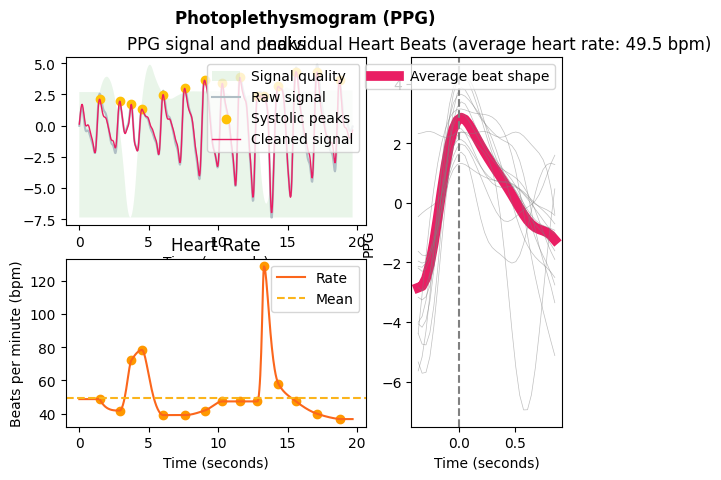

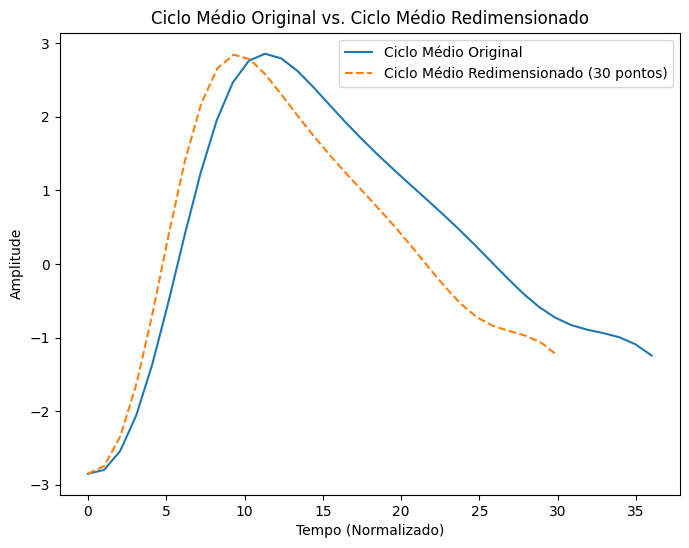

Qualidade: 0.890942514203871
      PPG_Raw  PPG_Clean   PPG_Rate  PPG_Quality  PPG_Peaks
0    0.000718  -0.296926  51.520572     0.936411          0
1   -0.176778  -0.545217  51.520572     0.936411          0
2   -0.389192  -0.823931  51.520572     0.936411          0
3   -0.666537  -1.162999  51.520572     0.936411          0
4   -1.026191  -1.579703  51.520572     0.936411          0
..        ...        ...        ...          ...        ...
585  0.496015   1.483851  46.153846     0.989766          0
586  0.221810   1.282616  46.153846     0.989766          0
587  0.063875   1.194296  46.153846     0.989766          0
588  0.017526   1.212405  46.153846     0.989766          0
589  0.039460   1.291632  46.153846     0.989766          0

[590 rows x 5 columns]
34


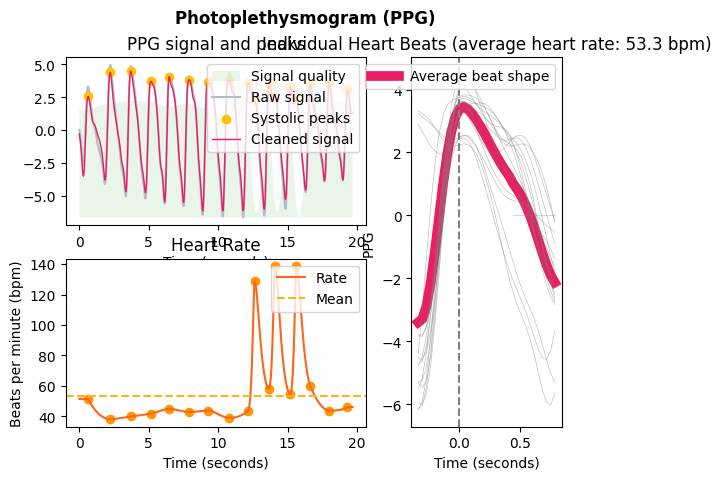

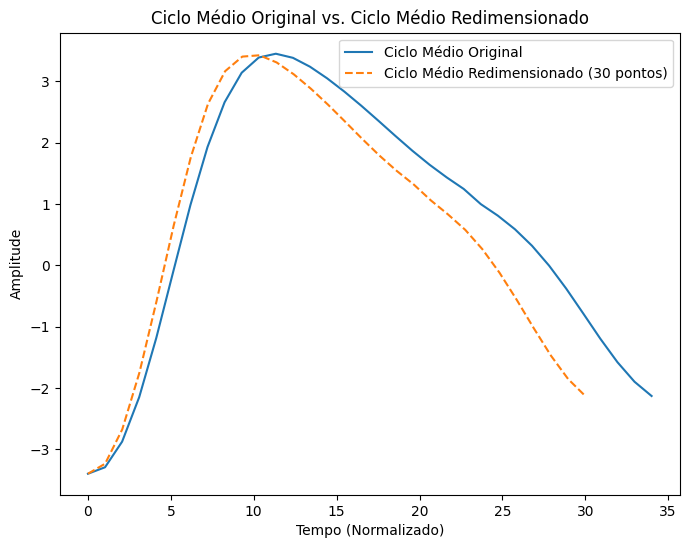

Qualidade: 0.9899152320758099
      PPG_Raw  PPG_Clean   PPG_Rate  PPG_Quality  PPG_Peaks
0    0.090019  -0.011005  43.494424     0.987297          0
1    0.422791   0.457320  43.494424     0.987297          0
2    0.674237   0.836055  43.494424     0.987297          0
3    0.779474   1.059365  43.494424     0.987297          0
4    0.703512   1.091388  43.494424     0.987297          0
..        ...        ...        ...          ...        ...
585 -7.137966  -7.736823  36.000000     0.989011          0
586 -5.948894  -6.779486  36.000000     0.989011          0
587 -4.279332  -5.348359  36.000000     0.989011          0
588 -2.243110  -3.553767  36.000000     0.989011          0
589 -0.008435  -1.560029  36.000000     0.989011          0

[590 rows x 5 columns]
41


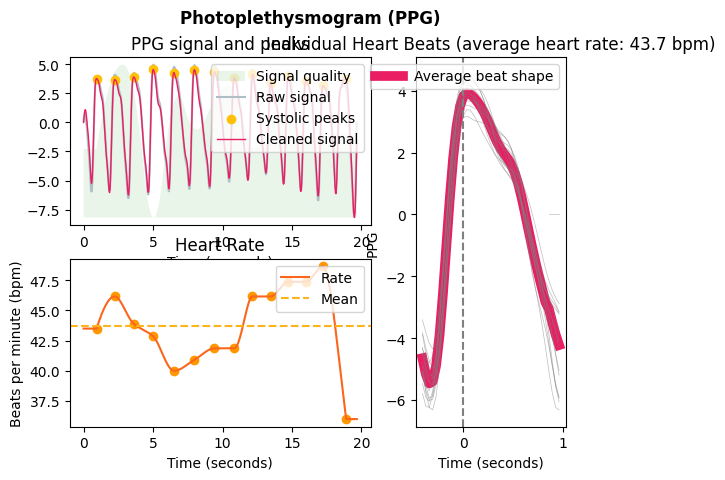

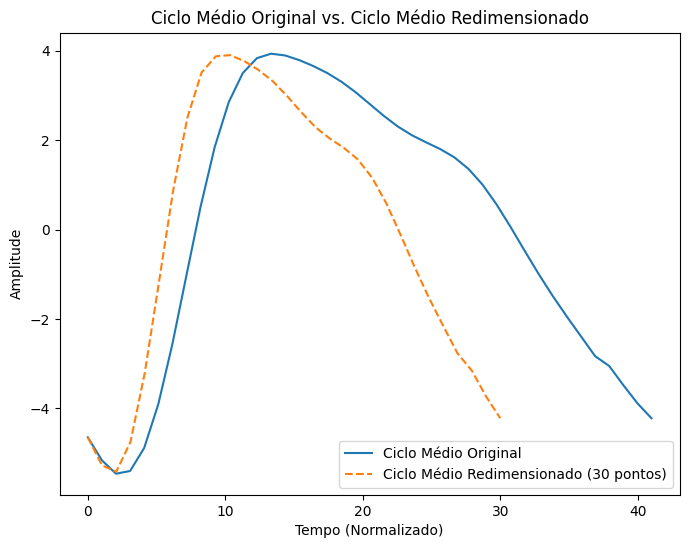

In [ ]:
import neurokit2 as nk
import numpy as np
from scipy.interpolate import interp1d
import pandas as pd

np.random.seed(SEED)
# df_nk = df_final.copy()
df_nk = df_filtered.copy()
# indexes = np.random.choice(df_nk.index, 3, replace=False)
indexes = [12,13,14]

# Interpolar o average_pulse para que tenha exatamente n_points
def resize_pulse(signal, target_size):
    current_size = len(signal)
    x_old = np.linspace(0, 1, current_size)
    x_new = np.linspace(0, 1, target_size)
    interpolator = interp1d(x_old, signal, kind='linear')
    return interpolator(x_new)

n_points = 30
quality_threshold = 0.8  # Threshold para qualidade dos batimentos

for i, index in enumerate(indexes):
    signals, info = nk.ppg_process(df_nk['ppg_r'][index], sampling_rate=30)
    cleaned_ppg = signals["PPG_Clean"]
    peaks = info["PPG_Peaks"]
    quality = signals["PPG_Quality"]  # Obter qualidade do sinal
    print(f"Qualidade: {quality.mean()}")

    nk.ppg_plot(signals, info)

    epochs = nk.ppg_segment(cleaned_ppg, peaks, sampling_rate=df_nk['fs'][index])
    print(signals)

    pulses_df = nk.epochs_to_df(epochs)
    average_pulse = pulses_df.groupby("Time")["Signal"].mean()
    print(len(average_pulse))

    # Redimensionar a forma do pulso médio
    average_pulse_resized = resize_pulse(average_pulse.values, n_points)

    # Plotar o pulso original e o interpolado
    plt.figure(figsize=(8, 6))
    plt.plot(np.linspace(0, len(average_pulse), len(average_pulse)), average_pulse, label="Ciclo Médio Original")
    plt.plot(np.linspace(0, len(average_pulse_resized), len(average_pulse_resized)), average_pulse_resized, label="Ciclo Médio Redimensionado (30 pontos)", linestyle="--")
    plt.xlabel("Tempo (Normalizado)")
    plt.ylabel("Amplitude")
    plt.title("Ciclo Médio Original vs. Ciclo Médio Redimensionado")
    plt.legend()
    plt.show()



#### Extração de ciclos

In [ ]:
import neurokit2 as nk
import numpy as np
from scipy.interpolate import interp1d
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(SEED)
df_nk = df_filtered.copy()

# Definir número de pontos para redimensionamento
n_points = 30
quality_threshold = 0.6
# Lista para armazenar os resultados
results = []
# Função para redimensionar a forma do pulso médio
def resize_pulse(signal, target_size):
    current_size = len(signal)
    x_old = np.linspace(0, 1, current_size)
    x_new = np.linspace(0, 1, target_size)
    interpolator = interp1d(x_old, signal, kind='linear')
    return interpolator(x_new)

# Função para processar um sinal PPG e calcular o pulso médio
def process_ppg_signal(ppg_signal, sampling_rate=30, quality_threshold=0.8, n_points=30):
    try:
        # Processar o PPG
        signals, info = nk.ppg_process(ppg_signal, sampling_rate=sampling_rate)
        cleaned_ppg = signals["PPG_Clean"]
        peaks = info["PPG_Peaks"]
        quality = signals["PPG_Quality"]

        # Segmentar e calcular o pulso médio
        epochs = nk.ppg_segment(cleaned_ppg, peaks, sampling_rate=sampling_rate)
        pulses_df = nk.epochs_to_df(epochs)
        average_pulse = pulses_df.groupby("Time")["Signal"].mean()

        # Redimensionar o pulso médio
        average_pulse_resized = resize_pulse(average_pulse.values, n_points)

        return average_pulse_resized, quality.mean()
    except Exception as e:
        print(f"Erro ao processar o sinal PPG: {e}")
        return None, None


for i, index in enumerate(tqdm(df_nk.index, desc="Processando registros")):
    # Obter os sinais PPG (R, G, B)
    ppg_signals = {
        "ppg_r": df_nk['ppg_r'][index],
        "ppg_g": df_nk['ppg_g'][index],
        "ppg_b": df_nk['ppg_b'][index]
    }

    row = {"Glycaemia [mg/dL]": df_nk.loc[index, "Glycaemia [mg/dL]"]}

    discard_sample = False
    for channel, signal in ppg_signals.items():
        if not isinstance(signal, np.ndarray) or len(signal) < 2:
            print(f"Sinal inválido ({channel}) no índice {index}. Pulando...")
            discard_sample = True
            break

        # Processar o sinal PPG
        average_pulse_resized, quality_mean = process_ppg_signal(signal, sampling_rate=df_nk['fs'][index])

        if average_pulse_resized is None:
            print(f"Sinal {channel} com qualidade abaixo do threshold no índice {index}. Descartando amostra...")
            discard_sample = True
            break

        # Adicionar os pontos redimensionados ao dicionário
        for j in range(n_points):
            row[f"{channel}_Point_{j}"] = average_pulse_resized[j]
        # row[f"{channel}_Quality"] = quality_mean
    if discard_sample:
        continue
    # Adicionar linha ao resultado
    results.append(row)


Processando registros: 100%|██████████| 21/21 [00:13<00:00,  1.53it/s]


In [ ]:
# Converter a lista de resultados para um DataFrame
result_df = pd.DataFrame(results)

# Exibir o DataFrame final
print(result_df.head())
print(result_df.shape)

   Glycaemia [mg/dL]  ppg_r_Point_0  ppg_r_Point_1  ppg_r_Point_2  \
0                106      -1.398347      -1.556267      -1.535725   
1                106      -1.709734      -1.808104      -1.724541   
2                106      -2.197684      -2.208879      -1.960938   
3                 84      -2.714083      -2.817407      -2.635931   
4                 84      -2.854952      -2.904609      -2.651095   

   ppg_r_Point_3  ppg_r_Point_4  ppg_r_Point_5  ppg_r_Point_6  ppg_r_Point_7  \
0      -1.292704      -0.815416      -0.214115       0.395038       0.892900   
1      -1.420969      -0.898367      -0.235296       0.437254       1.012332   
2      -1.440401      -0.686790       0.138918       0.896670       1.458981   
3      -2.085247      -1.199261      -0.164898       0.817354       1.583849   
4      -1.991614      -1.070698      -0.038802       0.890218       1.551545   

   ppg_r_Point_8  ...  ppg_b_Point_20  ppg_b_Point_21  ppg_b_Point_22  \
0       1.207717  ...        0.

#### Extração de features

In [ ]:
import pandas as pd

# Cálculo de diferenças e médias entre pontos consecutivos
def compute_interaction_features(df, channel_prefix, n_points):
    """
    Calcula diferenças e médias entre pontos consecutivos para um canal específico.
    Adiciona as novas colunas ao DataFrame original.

    Parâmetros:
    - df: DataFrame original.
    - channel_prefix: Prefixo do canal (ex.: "ppg_r").
    - n_points: Número de pontos no canal.
    """
    new_features = {}

    for i in range(n_points - 1):
        col1 = f"{channel_prefix}_Point_{i}"
        col2 = f"{channel_prefix}_Point_{i + 1}"

        # Diferença entre pontos consecutivos
        new_features[f"{channel_prefix}_Diff_{i}_{i+1}"] = df[col2] - df[col1]

        # Média entre pontos consecutivos
        new_features[f"{channel_prefix}_Avg_{i}_{i+1}"] = (df[col2] + df[col1]) / 2

    return pd.DataFrame(new_features)

# Número de pontos no canal
n_points = 30

# Computar features para cada canal
ppg_r_features = compute_interaction_features(result_df, "ppg_r", n_points)
ppg_g_features = compute_interaction_features(result_df, "ppg_g", n_points)
ppg_b_features = compute_interaction_features(result_df, "ppg_b", n_points)

# Combinar as novas features ao DataFrame original
result_df = pd.concat([result_df, ppg_r_features, ppg_g_features, ppg_b_features], axis=1)

# Verificar o DataFrame resultante
result_df.head()


,Glycaemia [mg/dL],ppg_r_Point_0,ppg_r_Point_1,ppg_r_Point_2,ppg_r_Point_3,ppg_r_Point_4,ppg_r_Point_5,ppg_r_Point_6,ppg_r_Point_7,ppg_r_Point_8,...,ppg_b_Diff_24_25,ppg_b_Avg_24_25,ppg_b_Diff_25_26,ppg_b_Avg_25_26,ppg_b_Diff_26_27,ppg_b_Avg_26_27,ppg_b_Diff_27_28,ppg_b_Avg_27_28,ppg_b_Diff_28_29,ppg_b_Avg_28_29
0,106,-1.398347,-1.556267,-1.535725,-1.292704,-0.815416,-0.214115,0.395038,0.892900,1.207717,...,-0.034382,-0.130096,-0.024542,-0.159558,-0.027950,-0.185805,-0.045188,-0.222374,-0.066488,-0.278212
1,106,-1.709734,-1.808104,-1.724541,-1.420969,-0.898367,-0.235296,0.437254,1.012332,1.384286,...,-0.054902,-0.236790,-0.047124,-0.287803,-0.043599,-0.333164,-0.048044,-0.378985,-0.056501,-0.431258
2,106,-2.197684,-2.208879,-1.960938,-1.440401,-0.686790,0.138918,0.896670,1.458981,1.778124,...,-0.064102,-0.331457,-0.038073,-0.382545,-0.019451,-0.411307,-0.022020,-0.432042,-0.039221,-0.462662
3,84,-2.714083,-2.817407,-2.635931,-2.085247,-1.199261,-0.164898,0.817354,1.583849,2.072974,...,-0.074590,-0.321977,-0.055734,-0.387139,-0.030426,-0.430219,-0.015211,-0.453037,-0.013483,-0.467384
4,84,-2.854952,-2.904609,-2.651095,-1.991614,-1.070698,-0.038802,0.890218,1.551545,1.933552,...,-0.089087,-0.414457,-0.045031,-0.481516,-0.012565,-0.510315,0.010964,-0.511115,0.054950,-0.478158


In [ ]:
import pandas as pd
import numpy as np

# Funções para calcular as novas features
def calculate_peak_to_valley(signal):
    """Calcula a diferença entre o pico (máximo) e o vale (mínimo) de um sinal."""
    return np.max(signal, axis=1) - np.min(signal, axis=1)

def calculate_slope(signal):
    """Calcula a inclinação (diferença entre pontos consecutivos)."""
    return np.mean(np.abs(np.diff(signal, axis=1)), axis=1)

def calculate_area(signal):
    """Calcula a área sob a curva (soma dos valores)."""
    return np.sum(signal, axis=1)

def calculate_integral_by_window(signal, window, sampling_interval=1):
    """
    Calcula a área sob a curva para janelas específicas usando integração (regra do trapézio).

    Parâmetros:
    - signal: numpy array 2D, onde cada linha é um sinal PPG.
    - window: Tamanho da janela (quantidade de pontos em cada segmento).
    - sampling_interval: Intervalo de amostragem (padrão: 1, para sinais uniformes).

    Retorno:
    - areas: numpy array 2D, onde cada linha contém as áreas para cada janela.
    """
    num_points = signal.shape[1]
    num_windows = num_points // window  # Número de janelas completas
    areas = np.zeros((signal.shape[0], num_windows))  # Inicializar matriz para áreas

    for i in range(num_windows):
        start = i * window
        end = start + window
        areas[:, i] = np.trapz(signal[:, start:end], dx=sampling_interval, axis=1)

    return areas

# Aplicar funções para cada canal
def add_waveform_features(df, channel_prefix):
    """
    Adiciona features baseadas na forma da onda para um canal específico.
    - df: DataFrame com os dados.
    - channel_prefix: Prefixo das colunas do canal (ex: 'ppg_r_').
    """
    # Selecionar apenas os pontos do canal
    point_columns = [col for col in df.columns if col.startswith(f"{channel_prefix}Point_")]
    signal = df[point_columns].values
    window = 5  # Tamanho da janela (10 pontos)
    sampling_interval = 1  # Intervalo de amostragem (ex: 1 segundo)
    areas = calculate_integral_by_window(signal, window, sampling_interval=sampling_interval)
    for i in range(areas.shape[1]):
        result_df[f"{channel_prefix}Area_Window_{i}"] = areas[:, i]

    return df

# Aplicar as features aos canais R, G e B
result_df = add_waveform_features(result_df, "ppg_r_")
result_df = add_waveform_features(result_df, "ppg_g_")
result_df = add_waveform_features(result_df, "ppg_b_")


## Separação de features

#### Seleção de features para treinamento

In [ ]:
import pandas as pd

X = result_df.drop(columns=['Glycaemia [mg/dL]'])
y = result_df['Glycaemia [mg/dL]']


print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (21, 282)
y shape: (21,)


In [ ]:
print(X.head())

   ppg_r_Point_0  ppg_r_Point_1  ppg_r_Point_2  ppg_r_Point_3  ppg_r_Point_4  \
0      -1.398347      -1.556267      -1.535725      -1.292704      -0.815416   
1      -1.709734      -1.808104      -1.724541      -1.420969      -0.898367   
2      -2.197684      -2.208879      -1.960938      -1.440401      -0.686790   
3      -2.714083      -2.817407      -2.635931      -2.085247      -1.199261   
4      -2.854952      -2.904609      -2.651095      -1.991614      -1.070698   

   ppg_r_Point_5  ppg_r_Point_6  ppg_r_Point_7  ppg_r_Point_8  ppg_r_Point_9  \
0      -0.214115       0.395038       0.892900       1.207717       1.341259   
1      -0.235296       0.437254       1.012332       1.384286       1.543677   
2       0.138918       0.896670       1.458981       1.778124       1.887184   
3      -0.164898       0.817354       1.583849       2.072974       2.261588   
4      -0.038802       0.890218       1.551545       1.933552       2.055740   

   ...  ppg_g_Area_Window_2  ppg_g_Are

# Teste do Modelo

### Config

In [ ]:
# https://github.com/kriventsov/Clarke-and-Parkes-Error-Grids/blob/master/error_grids.py
"""
Implementation of Clarke and Parkes error grid analysis
"""

import numpy as np

def clarke_error_zone_detailed(act, pred):
    """
    This function outputs the Clarke Error Grid region (encoded as integer)
    for a combination of actual and predicted value

    Based on 'Evaluating clinical accuracy of systems for self-monitoring of blood glucose':
    https://care.diabetesjournals.org/content/10/5/622
    """
    # Zone A
    if (act < 70 and pred < 70) or abs(act - pred) < 0.2 * act:
        return 0
    # Zone E - left upper
    if act <= 70 and pred >= 180:
        return 8
    # Zone E - right lower
    if act >= 180 and pred <= 70:
        return 7
    # Zone D - right
    if act >= 240 and 70 <= pred <= 180:
        return 6
    # Zone D - left
    if act <= 70 <= pred <= 180:
        return 5
    # Zone C - upper
    if 70 <= act <= 290 and pred >= act + 110:
        return 4
    # Zone C - lower
    if 130 <= act <= 180 and pred <= (7/5) * act - 182:
        return 3
    # Zone B - upper
    if act < pred:
        return 2
    # Zone B - lower
    return 1

def parkes_error_zone_detailed(act, pred, diabetes_type):
    """
    This function outputs the Parkes Error Grid region (encoded as integer)
    for a combination of actual and predicted value
    for type 1 and type 2 diabetic patients

    Based on the article 'Technical Aspects of the Parkes Error Grid':
    https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3876371/
    """
    def above_line(x_1, y_1, x_2, y_2, strict=False):
        if x_1 == x_2:
            return False

        y_line = ((y_1 - y_2) * act + y_2 * x_1 - y_1 * x_2) / (x_1 - x_2)
        return pred > y_line if strict else pred >= y_line

    def below_line(x_1, y_1, x_2, y_2, strict=False):
        return not above_line(x_1, y_1, x_2, y_2, not strict)

    def parkes_type_1(act, pred):
        # Zone E
        if above_line(0, 150, 35, 155) and above_line(35, 155, 50, 550):
            return 7
        # Zone D - left upper
        if (pred > 100 and above_line(25, 100, 50, 125) and
                above_line(50, 125, 80, 215) and above_line(80, 215, 125, 550)):
            return 6
        # Zone D - right lower
        if (act > 250 and below_line(250, 40, 550, 150)):
            return 5
        # Zone C - left upper
        if (pred > 60 and above_line(30, 60, 50, 80) and
                above_line(50, 80, 70, 110) and above_line(70, 110, 260, 550)):
            return 4
        # Zone C - right lower
        if (act > 120 and below_line(120, 30, 260, 130) and below_line(260, 130, 550, 250)):
            return 3
        # Zone B - left upper
        if (pred > 50 and above_line(30, 50, 140, 170) and
                above_line(140, 170, 280, 380) and (act < 280 or above_line(280, 380, 430, 550))):
            return 2
        # Zone B - right lower
        if (act > 50 and below_line(50, 30, 170, 145) and
                below_line(170, 145, 385, 300) and (act < 385 or below_line(385, 300, 550, 450))):
            return 1
        # Zone A
        return 0

    def parkes_type_2(act, pred):
        # Zone E
        if (pred > 200 and above_line(35, 200, 50, 550)):
            return 7
        # Zone D - left upper
        if (pred > 80 and above_line(25, 80, 35, 90) and above_line(35, 90, 125, 550)):
            return 6
        # Zone D - right lower
        if (act > 250 and below_line(250, 40, 410, 110) and below_line(410, 110, 550, 160)):
            return 5
        # Zone C - left upper
        if (pred > 60 and above_line(30, 60, 280, 550)):
            return 4
        # Zone C - right lower
        if (below_line(90, 0, 260, 130) and below_line(260, 130, 550, 250)):
            return 3
        # Zone B - left upper
        if (pred > 50 and above_line(30, 50, 230, 330) and
                (act < 230 or above_line(230, 330, 440, 550))):
            return 2
        # Zone B - right lower
        if (act > 50 and below_line(50, 30, 90, 80) and below_line(90, 80, 330, 230) and
                (act < 330 or below_line(330, 230, 550, 450))):
            return 1
        # Zone A
        return 0

    if diabetes_type == 1:
        return parkes_type_1(act, pred)

    if diabetes_type == 2:
        return parkes_type_2(act, pred)

    raise Exception('Unsupported diabetes type')

clarke_error_zone_detailed = np.vectorize(clarke_error_zone_detailed)
parkes_error_zone_detailed = np.vectorize(parkes_error_zone_detailed)

def zone_accuracy(act_arr, pred_arr, mode='clarke', detailed=False, diabetes_type=1):
    """
    Calculates the average percentage of each zone based on Clarke or Parkes
    Error Grid analysis for an array of predictions and an array of actual values
    """
    acc = np.zeros(9)
    if mode == 'clarke':
        res = clarke_error_zone_detailed(act_arr, pred_arr)
    elif mode == 'parkes':
        res = parkes_error_zone_detailed(act_arr, pred_arr, diabetes_type)
    else:
        raise Exception('Unsupported error grid mode')

    acc_bin = np.bincount(res)
    acc[:len(acc_bin)] = acc_bin

    if not detailed:
        acc[1] = acc[1] + acc[2]
        acc[2] = acc[3] + acc[4]
        acc[3] = acc[5] + acc[6]
        acc[4] = acc[7] + acc[8]
        acc = acc[:5]

    return acc / sum(acc)

In [ ]:
# https://www.researchgate.net/figure/Parkes-error-grid-This-grid-assigns-an-error-severity-level-from-A-to-E-E-high-based_fig2_358820426

import numpy as np
import plotly.graph_objects as go
import numpy as np
import plotly.graph_objects as go

def plot_error_grid(y_real, y_pred, y_min=None, y_max=None, diabetes_type=1, err_grid="clarke", annotation=None):
    """
    Plota o Parkes Error Grid usando os valores reais e previstos.

    Parâmetros:
    - y_real: array-like, valores reais.
    - y_pred: array-like, valores previstos.
    - diabetes_type: int, tipo de diabetes (1 ou 2).
    - title: str, título do gráfico.

    Retorna:
    - None. Exibe o gráfico interativo.
    """
    # Garantir que os dados são arrays NumPy
    y_r = np.array(y_real)
    y_p = np.array(y_pred)

    # Calcular zonas usando Parkes Error Grid (para diabetes tipo 1)
    if err_grid == "parkes":
        title="Parkes Error Grid"
        zones = parkes_error_zone_detailed(y_r, y_p, diabetes_type)
    else:
        title="Clarke Error Grid"
        zones = clarke_error_zone_detailed(y_r, y_p)
    # Mapear cores para cada zona
    zone_colors = {'A': 'green', 'B': 'yellow', 'C': 'orange', 'D': 'red', 'E': 'purple'}

    # Mapeamento numérico para letras das zonas
    zone_labels = {0: 'A', 1: 'B', 2: 'B', 3: 'C', 4: 'C', 5: 'D', 6: 'D', 7: 'E', 8: 'E'}

    # Agrupar dados por zona
    zone_data = {}
    for i, zone in enumerate(zones):
        label = zone_labels[zone]
        if label not in zone_data:
            zone_data[label] = {'x': [], 'y': [], 'indices': []}
        zone_data[label]['x'].append(y_r[i])
        zone_data[label]['y'].append(y_p[i])
        zone_data[label]['indices'].append(i)  # Adiciona os índices

    # Calcular porcentagens para cada zona
    total_points = len(zones)
    zone_counts = {label: len(data['x']) for label, data in zone_data.items()}
    zone_percentages = {label: (count / total_points) * 100 for label, count in zone_counts.items()}

    # Exibir porcentagens
    print("Porcentagens por Zona:")
    for label, percentage in zone_percentages.items():
        print(f"Zona {label}: {percentage:.2f}%")

    # Criar gráfico de dispersão
    fig = go.Figure()

    # Adicionar pontos para cada zona (A, B, C, D, E)
    for label, data in zone_data.items():
        fig.add_trace(go.Scatter(
            x=data['x'],
            y=data['y'],
            mode='markers',
            marker=dict(size=8, color=zone_colors[label], opacity=0.7),
            text=data['indices'],  # Adiciona os índices
            hovertemplate="<b>Índice:</b> %{text}<br>" +  # Mostra índice
                          "<b>Real:</b> %{x:.2f}<br>" +  # Valor real
                          "<b>Previsto:</b> %{y:.2f}<br>" +  # Valor previsto
                          f"<b>Zona:</b> {label}<extra></extra>",
            name=f'Zona {label}'
        ))

    fig_y_min = 0
    fig_y_max = max(y_r)
    if y_max is not None:
        fig_y_max = y_max
    if y_min is not None:
        fig_y_min = y_min

    # Adicionar linha de identidade (y = x)
    fig.add_trace(go.Scatter(
        x=[fig_y_min, fig_y_max],
        y=[fig_y_min, fig_y_max],
        mode='lines',
        line=dict(color='black', dash='dash'),
        name='Identidade'
    ))

    if annotation is not None:
        # Verificar se annotation é um array
        if isinstance(annotation, list):
            # Concatenar as strings do array com quebras de linha
            text = "<br>".join(annotation)
        else:
            # Usar diretamente a string única
            text = annotation

        # Adicionar a anotação ao gráfico
        fig.add_annotation(
            xref="paper", yref="paper",
            x=0.05, y=0.95,
            text=text,
            showarrow=False,
            font=dict(size=12)
        )
    # Configurações do layout
    fig.update_layout(
        title=title,
        xaxis_title="Valores Reais de Glicemia",
        yaxis_title="Previsões de Glicemia",
        showlegend=True,
        template="plotly_white",
        width=800,
        height=800
    )

    # Mostrar gráfico
    fig.show()


### Normalização

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Padronizar os dados para o PCA
scaler = StandardScaler()
scaler.set_output(transform='pandas')
X_scaled = scaler.fit_transform(X)


In [ ]:
print(X_scaled.shape)

(21, 282)


## Inicialização do Modelo

In [ ]:

from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error, mean_squared_log_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

model_path_sem_pca = "/content/drive/MyDrive/Colab Notebooks/Mestrado/Visao/catboost_model_glicemia_finger.cbm"


model_path = model_path_sem_pca

X_final = X_scaled

In [ ]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error, mean_squared_log_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time


# Carregar o modelo
loaded_model = CatBoostRegressor()
loaded_model.load_model(model_path)


## Teste

### Predição

In [ ]:
# Usar o modelo para previsões
# Iniciar o cronômetro
start_time = time.time()

y_pred = loaded_model.predict(X_final)

# Tempo de treinamento
training_time_cat_pca = time.time() - start_time

# Calcular as métricas
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y, y_pred)
r2 = r2_score(y, y_pred)
mape = mean_absolute_percentage_error(y, y_pred) * 100
msle = mean_squared_log_error(y, y_pred)
rmsle = rmsle = np.sqrt(msle)


# Exibir as métricas
print("\nCatBoost Regressor:")
print(f"MAE: {mae:.2f} mg/dL")
print(f"MAPE: {mape:.2f}%")
# print(f"MSE: {mse:.2f} mg²/dL²")
print(f"RMSE: {rmse:.2f} mg/dL")
print(f"R²: {r2:.2f}")
# print(f"RMSLE: {rmsle:.2f}")

print(f"Tempo de Predição: {training_time_cat_pca*1000:.3f} ms")


CatBoost Regressor:
MAE: 23.07 mg/dL
MAPE: 20.51%
RMSE: 26.81 mg/dL
R²: -0.19
Tempo de Predição: 29.302 ms


## Resultados

In [ ]:
plot_error_grid(y, y_pred, y_min=50, y_max=250, annotation=[
    f"MAE: {mae:.2f} mg/dL",
    f"MAPE: {mape:.2f}%",
    f"RMSE: {rmse:.2f} mg/dL"
])

Porcentagens por Zona:
Zona A: 57.14%
Zona B: 42.86%


In [ ]:
plot_error_grid(y, y_pred, y_min=50, y_max=250, err_grid="parkes", annotation=[
    f"MAE: {mae:.2f} mg/dL",
    f"MAPE: {mape:.2f}%",
    f"RMSE: {rmse:.2f} mg/dL"
])

Porcentagens por Zona:
Zona A: 57.14%
Zona B: 42.86%


In [ ]:
print(df_nk)

                                                ppg_r  \
0   [0.02249432752242564, -0.0072633575603548994, ...   
1   [-0.004808937560166565, 0.1297731973097101, 0....   
2   [-0.0039392176590182515, 0.5128117163534867, 0...   
3   [0.05112875314377899, 0.13598609817520607, 0.2...   
4   [-0.016449860638637043, 0.3217085095542997, 0....   
5   [0.05154892741540851, -0.34648160679990747, -0...   
6   [-0.011744059514821631, -0.1405952872136577, -...   
7   [0.0026729000375008694, -0.16233015323669847, ...   
8   [-0.001233660582116325, -0.24151313217061074, ...   
9   [-0.013067857687024259, -0.014730990822804213,...   
10  [-0.011620135972806145, -0.31780848914159104, ...   
11  [0.044999417927218344, -0.7446290326675239, -1...   
12  [-0.007556599683082338, 0.36634825542137694, 0...   
13  [0.0007177011732048544, -0.1767783119096994, -...   
14  [0.0900193111743208, 0.4227905144872973, 0.674...   
15  [-0.011776285077491233, -0.045466064460372685,...   
16  [-0.016453489416065142, -0.

In [ ]:
print(df_nk.index)

RangeIndex(start=0, stop=21, step=1)


In [ ]:
pip install plotly

In [ ]:
import plotly.io as pio
pio.renderers.default = "colab"

In [ ]:
import neurokit2 as nk
import numpy as np
from scipy.interpolate import interp1d
import pandas as pd


# Iterar pelos índices específicos
indices = [8]  # Substitua pelos índices desejados
for i, index in enumerate(indices):
    print(f"Index: {index}")

    # Processar e plotar cada canal (R, G, B)
    for channel in ["ppg_r", "ppg_g", "ppg_b"]:
        print(f"Processando canal: {channel}")

        # Obter o sinal do canal específico
        ppg_signal = df_nk[channel][index]

        # Processar o sinal do canal PPG
        signals, info = nk.ppg_process(ppg_signal, sampling_rate=60)
        cleaned_ppg = signals["PPG_Clean"]
        peaks = info["PPG_Peaks"]
        quality = signals["PPG_Quality"]  # Obter qualidade do sinal

        # # Avaliar a qualidade do sinal
        print(f"Qualidade do canal {channel}: {quality.mean()}")

        # Plotar o sinal processado
        print(f"Plotando o canal {channel} para o índice {index}")
        # nk.ppg_plot(signals, info,static=False)
        fig = nk.ppg_plot(signals, info, static=False)
        fig.show()

# Iterar pelos í

Index: 8
Processando canal: ppg_r
Qualidade do canal ppg_r: 0.9934273806579366
Plotando o canal ppg_r para o índice 8


Processando canal: ppg_g
Qualidade do canal ppg_g: 0.993943896657335
Plotando o canal ppg_g para o índice 8


Processando canal: ppg_b
Qualidade do canal ppg_b: 0.9908939441124225
Plotando o canal ppg_b para o índice 8
